In [1]:
%%capture
%pip install -r ../requirements.txt

In [2]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

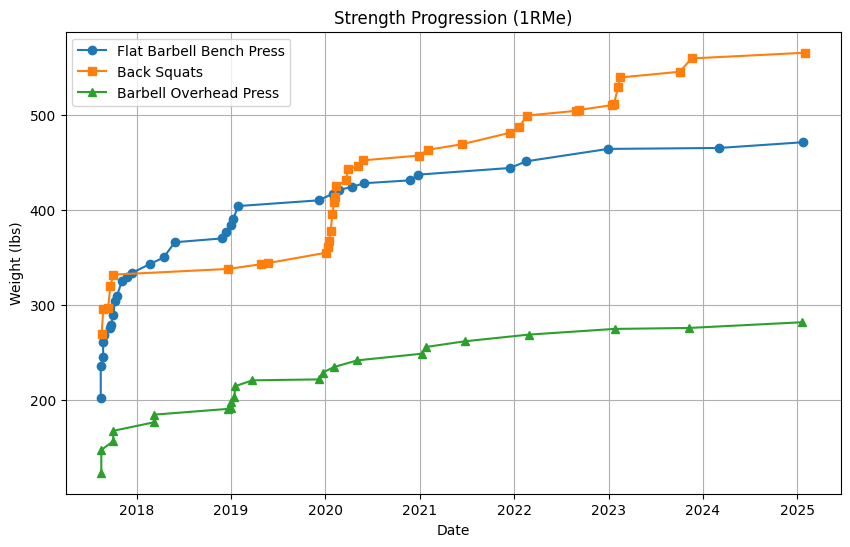

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect data for each exercise
exercises = ["Flat Barbell Bench Press", "Back Squats", "Barbell Overhead Press"]
exercise_data = {ex: [] for ex in exercises}

for workout in wld.workouts:
    for exercise in workout.exercises:
        key = exercise.displayName()
        if key in exercises:
            for set_data in exercise.sets:
                if set_data.weight is not None:  # Only include sets with weight data
                    exercise_data[key].append({
                        "date": workout.date,
                        "weight": set_data.oneRM
                    })

# Convert to DataFrames and get max progressions
max_dfs = {}
for exercise in exercises:
    # Convert to DataFrame and sort
    df = pd.DataFrame(exercise_data[exercise])
    if not df.empty:
        df = df.sort_values("date")

        # Get max progression
        running_max = 0
        max_data = []
        for _, row in df.iterrows():
            if row["weight"] > running_max:
                running_max = row["weight"]
                max_data.append({"date": row["date"], "weight": row["weight"]})

        max_dfs[exercise] = pd.DataFrame(max_data)

# Plot progression for all exercises
plt.figure(figsize=(10, 6))
markers = ['o', 's', '^']
for exercise, marker in zip(exercises, markers):
    if exercise in max_dfs and not max_dfs[exercise].empty:
        plt.plot(max_dfs[exercise]["date"], max_dfs[exercise]["weight"],
                marker=marker, label=exercise)

plt.title("Strength Progression (1RMe)")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.grid(True)
plt.legend()
plt.show()

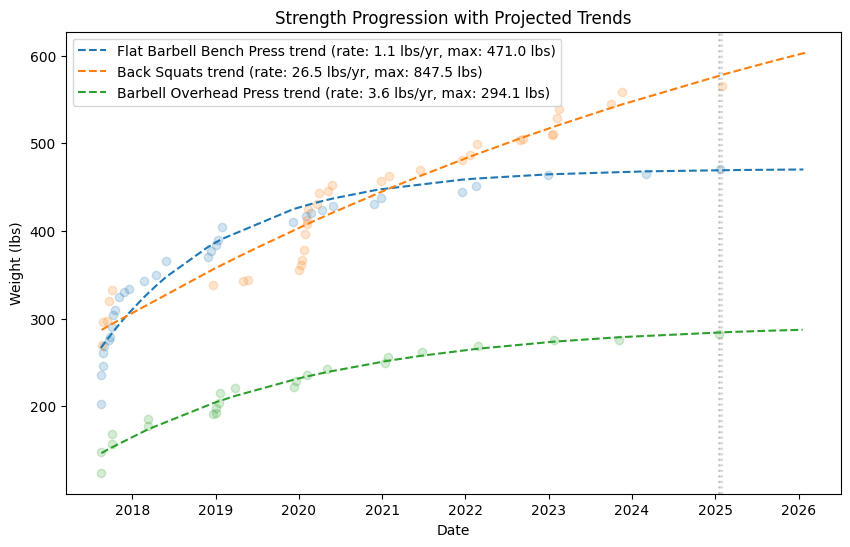

In [4]:
import numpy as np
from matplotlib.dates import date2num
from datetime import timedelta

# Define asymptotic function (y = a - b*e^(-cx))
def asymptotic_func(x, a, b, c):
    return a - b * np.exp(-c * x)

# Add trendlines and projections
plt.figure(figsize=(10, 6))
for exercise in max_dfs:
    if exercise in max_dfs and not max_dfs[exercise].empty:
        df = max_dfs[exercise]
        dates = df["date"].tolist()
        weights = df["weight"].tolist()

        # Plot original data points
        plt.scatter(dates, weights, alpha=0.2)

        # Convert dates to numeric values for trendline calculation
        date_nums = date2num(dates)
        min_date_num = min(date_nums)
        normalized_dates = date_nums - min_date_num

        try:
            # Fit asymptotic curve
            from scipy.optimize import curve_fit
            popt, _ = curve_fit(
                asymptotic_func,
                normalized_dates,
                weights,
                p0=[max(weights)*1.1, max(weights), 0.001],  # Initial guesses
                bounds=([max(weights), 0, 0], [max(weights)*1.5, max(weights)*2, 0.01])
            )

            # Create future dates for projection
            future_dates = dates + [dates[-1] + timedelta(days=x) for x in range(1, 366)]
            future_date_nums = date2num(future_dates)
            normalized_future_dates = future_date_nums - min_date_num

            # Calculate trendline including projection
            trendline = asymptotic_func(normalized_future_dates, *popt)

            # Calculate current rate of change
            def asymptotic_derivative(x, a, b, c):
                return b * c * np.exp(-c * x)
            current_rate = asymptotic_derivative(normalized_dates[-1], *popt) * 365

            # Plot trendline with projection
            plt.plot(future_dates, trendline, '--', alpha=1,
                    label=f'{exercise} trend (rate: {current_rate:.1f} lbs/yr, max: {popt[0]:.1f} lbs)')

            # Add vertical line at last actual data point
            plt.axvline(x=dates[-1], color='gray', linestyle=':', alpha=0.3)

        except:
            # Skip trendline if curve fitting fails
            continue

plt.title("Strength Progression with Projected Trends")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.legend()
plt.show()

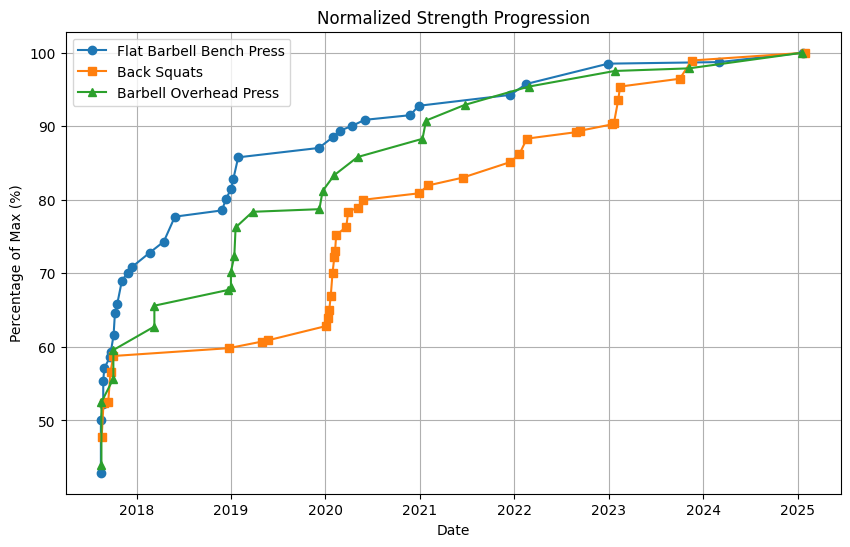

In [5]:
# Normalize the data to percentages of max for each exercise
norm_dfs = {}
for exercise in max_dfs:
    if not max_dfs[exercise].empty:
        df = max_dfs[exercise].copy()
        max_weight = df["weight"].max()
        df["weight"] = (df["weight"] / max_weight) * 100
        norm_dfs[exercise] = df

# Plot normalized progression
plt.figure(figsize=(10, 6))
markers = ['o', 's', '^']
for exercise, marker in zip(exercises, markers):
    if exercise in norm_dfs and not norm_dfs[exercise].empty:
        plt.plot(norm_dfs[exercise]["date"], norm_dfs[exercise]["weight"],
                marker=marker, label=exercise)

plt.title("Normalized Strength Progression")
plt.xlabel("Date")
plt.ylabel("Percentage of Max (%)")
plt.grid(True)
plt.legend()
plt.show()
